# Analyze DBTL1 proteomics

For DBTL1, we produced 2- and 3-gRNA P.Putida strains and did global proteomics. Here we analyze the proteomics data in order to filter strains by dCas9 expression and target inhibition.

## Input and output

## 1. Setup

### 1.1 Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

Define function for identifying if tests pass throughout the workbook: 

### 1.2 User parameters

In [2]:
user_params = {
    'output_dir'  : 'dbtl1_figures_and_analysis/',
    'protein_map' : './DBTL0_data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
}

### 1.3 Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [3]:
study_slug_1 = 'crispri-automation-for-enhanced-isoprenol-pro-fca3'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [4]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [5]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

  0%|          | 0/475488 [00:00<?, ?it/s]

There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [6]:
df['Protocol'].unique()

array(['GC-FID', 'Global Proteomics', 'Biolector'], dtype=object)

## 2. Preprocess and inspect data

### 2.1 Useful functions - preprocessing

In [7]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

### 2.2 Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [8]:
df

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,191107,CRISPRi automation for enhanced isoprenol prod...,191108,5ccffc96-15ea-4e75-89cc-e198de3bab69,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,191300,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,48.00000
1,191107,CRISPRi automation for enhanced isoprenol prod...,191109,82a2ac64-9ac2-46db-a26d-0325b57e876e,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,191301,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,48.00000
2,191107,CRISPRi automation for enhanced isoprenol prod...,191110,620d107d-a643-4f69-82ae-a11916dfda58,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,191302,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,48.00000
3,191107,CRISPRi automation for enhanced isoprenol prod...,191111,22e396ed-81f5-450c-a279-edb237b08008,PP_3123_PP_4862_PP_5186-R1,DBTL1_P1_004,GC-FID,191303,PP_3123_PP_4862_PP_5186-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,165.8082,48.00000
4,191107,CRISPRi automation for enhanced isoprenol prod...,191112,ebb85028-ca43-4492-8d70-df4ad3cbc762,PP_2137_PP_4116_PP_4187-R1,DBTL1_P1_005,GC-FID,191304,PP_2137_PP_4116_PP_4187-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,222.7008,48.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475483,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.4600,47.34472
475484,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.2800,47.51139
475485,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.0400,47.67806
475486,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,15.8700,47.84472


In [9]:
df['Protocol']=='Biolector'

0         False
1         False
2         False
3         False
4         False
          ...  
475483     True
475484     True
475485     True
475486     True
475487     True
Name: Protocol, Length: 475488, dtype: bool

In [10]:
df2 = df.loc[df['Protocol']!='Biolector']

In [11]:
df2.shape

(420096, 15)

Let's just keep the basic data types:

In [12]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [13]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(144,
 array(['DBTL1_P1_001', 'DBTL1_P1_002', 'DBTL1_P1_003', 'DBTL1_P1_004',
        'DBTL1_P1_005', 'DBTL1_P1_006', 'DBTL1_P1_007', 'DBTL1_P1_008',
        'DBTL1_P1_009', 'DBTL1_P1_010', 'DBTL1_P1_011', 'DBTL1_P1_012',
        'DBTL1_P1_013', 'DBTL1_P1_014', 'DBTL1_P1_015', 'DBTL1_P1_016',
        'DBTL1_P1_017', 'DBTL1_P1_018', 'DBTL1_P1_019', 'DBTL1_P1_020',
        'DBTL1_P1_021', 'DBTL1_P1_022', 'DBTL1_P1_023', 'DBTL1_P1_024',
        'DBTL1_P1_025', 'DBTL1_P1_026', 'DBTL1_P1_027', 'DBTL1_P1_028',
        'DBTL1_P1_029', 'DBTL1_P1_030', 'DBTL1_P1_031', 'DBTL1_P1_032',
        'DBTL1_P1_033', 'DBTL1_P1_034', 'DBTL1_P1_035', 'DBTL1_P1_036',
        'DBTL1_P1_037', 'DBTL1_P1_038', 'DBTL1_P1_039', 'DBTL1_P1_040',
        'DBTL1_P1_041', 'DBTL1_P1_042', 'DBTL1_P1_043', 'DBTL1_P1_044',
        'DBTL1_P1_045', 'DBTL1_P1_046', 'DBTL1_P1_047', 'DBTL1_P1_048',
        'DBTL1_P3_048', 'DBTL1_P3_049', 'DBTL1_P3_050', 'DBTL1_P3_051',
        'DBTL1_P3_052', 'DBTL1_P3_053', 'DBTL1_P3_054', 'D

In [14]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(192,
 array(['PP_0226_PP_0897_PP_5288-R1', 'PP_1319_PP_1457_PP_4192-R1',
        'PP_2213_PP_2471_PP_4266-R1', 'PP_3123_PP_4862_PP_5186-R1',
        'PP_2137_PP_4116_PP_4187-R1', 'PP_4189_PP_4550_PP_4862-R1',
        'PP_0813_PP_1769_PP_4191-R1', 'PP_0368_PP_4191_PP_4192-R1',
        'PP_0226_PP_0897_PP_5288-R2', 'PP_1319_PP_1457_PP_4192-R2',
        'PP_2213_PP_2471_PP_4266-R2', 'PP_3123_PP_4862_PP_5186-R2',
        'PP_2137_PP_4116_PP_4187-R2', 'PP_4189_PP_4550_PP_4862-R2',
        'PP_0813_PP_1769_PP_4191-R2', 'PP_0368_PP_4191_PP_4192-R2',
        'PP_0226_PP_0897_PP_5288-R3', 'PP_1319_PP_1457_PP_4192-R3',
        'PP_2213_PP_2471_PP_4266-R3', 'PP_3123_PP_4862_PP_5186-R3',
        'PP_2137_PP_4116_PP_4187-R3', 'PP_4189_PP_4550_PP_4862-R3',
        'PP_0813_PP_1769_PP_4191-R3', 'PP_0368_PP_4191_PP_4192-R3',
        'PP_0751_PP_1620_PP_4678-R1', 'PP_0813_PP_4549_PP_5288-R1',
        'PP_2112_PP_2136_PP_4678-R1', 'PP_0368_PP_0812_PP_0944-R1',
        'PP_0999_PP_3578_PP_5186-R1', 'PP_

In [15]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|A9GAJ9|A9GAJ9_SORC5 Mcm', 'sp|O77727', ...,
       'sp|Q9FD71|HMGCS_ENTFL', 'sp|Q9NSB2', 'sp|Q9Z408|CSD_PSEPK Csda'],
      dtype=object)

In [16]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [17]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

### 2.2 Add strain name to dataframe using prebuilt function.

In [18]:
df2["Strain"] = create_strain_names(df2)
print(df2.shape)

(420096, 7)


### 2.3 Bring out Uniprot names

In [19]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)
get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'
print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


<>:1: SyntaxWarning: invalid escape sequence '\|'
<>:1: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_17419/796388095.py:1: SyntaxWarning: invalid escape sequence '\|'
  get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)


In [20]:
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
0,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,173.9811,P1
1,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,268.6526,P1
2,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,182.8489,P1
3,PP_3123_PP_4862_PP_5186-R1,DBTL1_P1_004,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,165.8082,P1
4,PP_2137_PP_4116_PP_4187-R1,DBTL1_P1_005,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,222.7008,P1


In [21]:
print(df2.shape)

(420096, 7)


### 2.4 Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [22]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [23]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

#### 2.4.1 Protein-gene mapping sanity check
Need to check: is there a 1 to 1 correspondence between target genes and uniprot IDs?

There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [24]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets show up multiple times in the uniprot list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times in the target list')
print(upid_value_counts[upid_value_counts>1])


In the Protein Mapping spreadsheet, there are 123 unique target genes and 122 unique uniprot IDs
These targets show up multiple times in the uniprot list:
CRISPRi target gene
PP_1607    10
PP_0528     3
PP_0548     3
PP_4679     3
PP_4194     2
Name: count, dtype: int64
These Uniprot IDs show up multiple times in the target list
UNIPROT ID
Q88MG4    10
Q88DY9     3
Q88QG6     3
Q88QE6     3
Q88FA4     2
Q877U6     2
Name: count, dtype: int64


### 2.5 Drop non-target proteins

Add dCas9 to the Protein mapping dataframe

In [25]:
ProtMapping_df.loc[len(ProtMapping_df), ['CRISPRi target gene', 'UNIPROT ID']] = 'dCas9', 'Q99ZW2'

Make list of proteins

In [26]:
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()

We want to keep dCas9, so add it ot the list.

In [27]:
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
df2 = df2.drop(
                    index=df2[(~df2['Formal Type'].isin(targets_in_mapping)) &
                                  (df2['Protocol']=='Global Proteomics')].index)
print(df2.shape)

(19392, 7)


In [28]:
len(targets_in_mapping)

123

### 2.6 Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [29]:
uniprot_to_pp = {}
for index in ProtMapping_df.index:
    uniprot_to_pp[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

Do the translation:

In [30]:
proteomics_ind = df2['Protocol']=='Global Proteomics'
df2.loc[proteomics_ind,'Formal Type'] = df2.loc[proteomics_ind,'Formal Type'].apply(lambda x: uniprot_to_pp[x])

### 2.7 Add correct control value to each row in dataframe

In [31]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control).astype(bool)

In [32]:
control_mean_df = df2[df2['Control']]
control_mean_df = control_mean_df[['Formal Type', 'Value']].groupby('Formal Type').mean()
control_mean_df.loc['PP_0001', 'Value']

2354989.0900000003

In [33]:
add_control_value = lambda x: control_mean_df.loc[x, 'Value']
df2['control_value'] = df2['Formal Type'].apply(add_control_value)
df2['norm_value'] = df2['Value']/df2['control_value']

## 3. Format data to look at dCas9 and target expression vs controls

- Create a dataframe `df_target` where each row is a different line
- From proteomics, get dCas9 levels and target levels for each target in that line
- Get correct control measurements
- Calculate dCas9 and target levels relative to control. 

### 3.1 Make a new dataframe for each strain to add target and control expression
Dataframe will have proteomics measurements for dCas9 and target proteins only.

In [34]:
df_target = pd.DataFrame(data = df2['Line Name'].unique(), columns = ['Line Name'])

In [35]:
df_target

,Line Name
0,PP_0226_PP_0897_PP_5288-R1
1,PP_1319_PP_1457_PP_4192-R1
2,PP_2213_PP_2471_PP_4266-R1
3,PP_3123_PP_4862_PP_5186-R1
4,PP_2137_PP_4116_PP_4187-R1
...,...
187,PP_0437_PP_3365-R3
188,PP_1319_PP_4121_PP_4667-R3
189,PP_0814_PP_4192-R3
190,PP_0812_PP_4121-R3


Format `df_target` to contain replicate and control information and the line name without replicate information.

In [36]:
df_target = pd.DataFrame(data = df2['Line Name'].unique(), columns = ['Line Name'])
df_target['rep'] = df_target['Line Name'].apply(lambda x: int(x[-1]))
df_target['is_control'] = df_target['Line Name'].apply(find_control).astype(bool)

Replace all `line_name_norep` with 'Control' for controls, drop replicate information from non-control lines.

In [37]:
df_target.loc[df_target['is_control'], 'line_name_norep'] = 'Control'
df_target.loc[~df_target['is_control'] , 'line_name_norep'] = df_target.loc[~df_target['is_control'] , 'Line Name'].apply(lambda x: x[:-3])
df_target

,Line Name,rep,is_control,line_name_norep
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266
3,PP_3123_PP_4862_PP_5186-R1,1,False,PP_3123_PP_4862_PP_5186
4,PP_2137_PP_4116_PP_4187-R1,1,False,PP_2137_PP_4116_PP_4187
...,...,...,...,...
187,PP_0437_PP_3365-R3,3,False,PP_0437_PP_3365
188,PP_1319_PP_4121_PP_4667-R3,3,False,PP_1319_PP_4121_PP_4667
189,PP_0814_PP_4192-R3,3,False,PP_0814_PP_4192
190,PP_0812_PP_4121-R3,3,False,PP_0812_PP_4121


Add number of gRNA to dataframe

In [38]:
count_grna = lambda x: x.count('PP_')
df_target['number_of_grna'] = df2['Line Name'].apply(count_grna)

Define function to get specific fields from the full edd dataframe `df2` based on Line Names, check to see for missing or multiple values. 

In [39]:
def get_edd_value_by_linename(x, df_edd, df_edd_field, df_edd_value):
    """
    Return value from EDD-formatted dataframe for a specific line name (x['Line Name']) and a specific other field/value combination (df_edd_field/df_edd_value).
    x: dataframe
    df_edd: EDD formatted dataframe
    df_edd_field: field within df_edd to filter values
    df_edd_value: entry in df_edd[df_edd_field]
    
    Function also provides checks for length of 'value'
    """
    index = (df_edd['Line Name'] == x['Line Name']) & (df_edd[df_edd_field] == df_edd_value)
    value = df_edd.loc[index, 'Value'].values
    if len(value) == 1:
        return value[0]
    elif len(value) == 0:
        print(f"Line Name: {x['Line Name']}\t field: {df_edd_field}\t value: {df_edd_value} has missing value")
        return None
    else:
        return value
        print(f"Line Name: {x['Line Name']}\t field: {df_edd_field}\t value: {df_edd_value} has >1 values")

Fill in isoprenol, dCas9, and normalized dCas9 columns

In [40]:
df_target['isoprenol'] =df_target.apply(lambda x: get_edd_value_by_linename(x, df2, 'Formal Type', 'cid:12988'), axis = 1)

In [41]:
df_target['dCas9'] = df_target.apply(lambda x: get_edd_value_by_linename(x, df2, 'Formal Type', 'dCas9'), axis = 1)
df_target['dCas9_normtocontrol'] = df_target['dCas9']/np.mean(df_target.loc[df_target['is_control'], 'dCas9'])

Define function to parse gene lists using regex or return None if there isn't a gene at that position. 

In [42]:
def find_nth_gene_target(line_name, n):
    """
    line_name: a line name from a dataframe
    n: the n-th target gene to look for in the line name
    """
    gene_target_list = re.findall('PP_[0-9]{4}', line_name)
    #If target list is too short or empty, return None
    if n>=len(gene_target_list) or len(gene_target_list) == 0:
        return None
    else:
        return(gene_target_list[n])

Fill in target columns - function will return None for 'target_3' for 2-gRNA lines. Note that we also add a `target_4` field here and onwards to match with dataframes from later cycles.

In [43]:
df_target['target_1'] = df_target['Line Name'].apply(lambda x: find_nth_gene_target(x, 0))
df_target['target_2'] = df_target['Line Name'].apply(lambda x: find_nth_gene_target(x, 1))
df_target['target_3'] = df_target['Line Name'].apply(lambda x: find_nth_gene_target(x, 2))
df_target['target_4'] = df_target['Line Name'].apply(lambda x: find_nth_gene_target(x, 3))

Get list of unique targets and check to see that they're in control

In [44]:
all_targets = np.concatenate(df_target[['target_1', 'target_2', 'target_3']].values)
all_unique_targets = np.unique(all_targets[all_targets != None])
all_unique_targets

array(['PP_0226', 'PP_0368', 'PP_0437', 'PP_0528', 'PP_0597', 'PP_0658',
       'PP_0751', 'PP_0774', 'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815',
       'PP_0897', 'PP_0944', 'PP_0999', 'PP_1317', 'PP_1319', 'PP_1444',
       'PP_1457', 'PP_1506', 'PP_1607', 'PP_1620', 'PP_1769', 'PP_2095',
       'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339', 'PP_2471',
       'PP_3071', 'PP_3123', 'PP_3365', 'PP_3578', 'PP_3754', 'PP_3755',
       'PP_4011', 'PP_4116', 'PP_4120', 'PP_4121', 'PP_4122', 'PP_4186',
       'PP_4187', 'PP_4188', 'PP_4189', 'PP_4191', 'PP_4192', 'PP_4266',
       'PP_4549', 'PP_4550', 'PP_4651', 'PP_4667', 'PP_4678', 'PP_4679',
       'PP_4862', 'PP_5186', 'PP_5288'], dtype=object)

In [45]:
all_control_measurements = df2.loc[df2['Control'], 'Formal Type'].unique()

In [46]:
all_control_measurements

array(['cid:12988', 'PP_2471', 'PP_1506', 'PP_0001', 'PP_3365', 'PP_5419',
       'PP_5417', 'PP_5416', 'PP_5335', 'PP_5288', 'PP_5203', 'PP_5186',
       'PP_5128', 'PP_5064', 'PP_4894', 'PP_4862', 'PP_4702', 'PP_4679',
       'PP_4678', 'PP_4667', 'PP_4651', 'PP_4650', 'PP_4636', 'PP_4635',
       'PP_4549', 'PP_4487', 'PP_4266', 'PP_4194', 'PP_4193', 'PP_4192',
       'PP_4191', 'PP_4190', 'PP_4189', 'PP_4188', 'PP_4187', 'PP_4186',
       'PP_4185', 'PP_4175', 'PP_4174', 'PP_4130', 'PP_4129', 'PP_4128',
       'PP_4123', 'PP_4122', 'PP_4121', 'PP_4120', 'PP_4119', 'PP_4116',
       'PP_4012', 'PP_4011', 'PP_3755', 'PP_3754', 'PP_3578', 'PP_3123',
       'PP_3122', 'PP_3071', 'PP_2925', 'PP_2339', 'PP_2137', 'PP_2136',
       'PP_2112', 'PP_2095', 'PP_1777', 'PP_1770', 'PP_1769', 'PP_1755',
       'PP_1664', 'PP_1620', 'PP_1610', 'PP_1607', 'PP_1457', 'PP_1444',
       'PP_1319', 'PP_1318', 'PP_1317', 'PP_1251', 'PP_1240', 'PP_1031',
       'PP_1023', 'PP_0999', 'PP_0944', 'PP_0897'

In [47]:
targets_missing_from_control = [target for target in all_unique_targets if target not in all_control_measurements]
targets_missing_from_control

['PP_0815', 'PP_2213', 'PP_4550']

Use target identity to add target value to dataframe

In [48]:
print('~~~~~~~~target 1~~~~~~~~')
df_target['target_1_value'] = df_target.apply(lambda x: get_edd_value_by_linename(x, df2, 'Formal Type', x['target_1']), axis = 1)
print('~~~~~~~~target 2~~~~~~~~')
df_target['target_2_value'] = df_target.apply(lambda x: get_edd_value_by_linename(x, df2, 'Formal Type', x['target_2']), axis = 1)
print('~~~~~~~~target 3~~~~~~~~')
df_target['target_3_value'] = df_target.apply(lambda x: get_edd_value_by_linename(x, df2, 'Formal Type', x['target_3']), axis = 1)
print('~~~~~~~~target 4~~~~~~~~')
df_target['target_4_value'] = df_target.apply(lambda x: get_edd_value_by_linename(x, df2, 'Formal Type', x['target_4']), axis = 1)

~~~~~~~~target 1~~~~~~~~
Line Name: PP_2213_PP_2471_PP_4266-R1	 field: Formal Type	 value: PP_2213 has missing value
Line Name: PP_2213_PP_2471_PP_4266-R2	 field: Formal Type	 value: PP_2213 has missing value
Line Name: PP_2213_PP_2471_PP_4266-R3	 field: Formal Type	 value: PP_2213 has missing value
Line Name: Control_P1-R1	 field: Formal Type	 value: None has missing value
Line Name: Control_P1-R2	 field: Formal Type	 value: None has missing value
Line Name: Control_P1-R3	 field: Formal Type	 value: None has missing value
Line Name: Control_P2-R1	 field: Formal Type	 value: None has missing value
Line Name: Control_P2-R2	 field: Formal Type	 value: None has missing value
Line Name: Control_P2-R3	 field: Formal Type	 value: None has missing value
Line Name: Control_P3-R1	 field: Formal Type	 value: None has missing value
Line Name: Control_P3-R2	 field: Formal Type	 value: None has missing value
Line Name: Control_P3-R3	 field: Formal Type	 value: None has missing value
Line Name: PP_0

Define function to get the control value for each target

In [49]:
def get_target_control_mean(x, df_edd):
    """
    Get the control mean for a specific target.
    x: Measurement type (protein ID) to look for in EDD dataframe
    df_edd: EDD-formatted dataframe of proteomics measurements with a 'Control' field
    """
    control_idx = (df_edd['Formal Type'] == x) & df_edd['Control']
    control_mean = np.mean(df_edd.loc[control_idx, 'Value'])
    if any(control_idx):
        return control_mean
    else:
        if x is not None:
            print(f"formal type: {x}\t missing control values")
        return None

Get the value of the control for each target

In [50]:
df_target['target_1_control'] = df_target['target_1'].apply(lambda x: get_target_control_mean(x, df2))
df_target['target_2_control'] = df_target['target_2'].apply(lambda x: get_target_control_mean(x, df2))
df_target['target_3_control'] = df_target['target_3'].apply(lambda x: get_target_control_mean(x, df2))
df_target['target_4_control'] = df_target['target_3'].apply(lambda x: get_target_control_mean(x, df2))

formal type: PP_2213	 missing control values
formal type: PP_2213	 missing control values
formal type: PP_2213	 missing control values
formal type: PP_0815	 missing control values
formal type: PP_0815	 missing control values
formal type: PP_0815	 missing control values
formal type: PP_4550	 missing control values
formal type: PP_4550	 missing control values
formal type: PP_4550	 missing control values
formal type: PP_0815	 missing control values
formal type: PP_2213	 missing control values
formal type: PP_0815	 missing control values
formal type: PP_2213	 missing control values
formal type: PP_0815	 missing control values
formal type: PP_2213	 missing control values
formal type: PP_4550	 missing control values
formal type: PP_4550	 missing control values
formal type: PP_4550	 missing control values


Fill in dataframe with target values normalized to control.

In [51]:
df_target['target_1_norm'] = df_target['target_1_value']/df_target['target_1_control']
df_target['target_2_norm'] = df_target['target_2_value']/df_target['target_2_control']
df_target['target_3_norm'] = df_target['target_3_value']/df_target['target_3_control']
df_target['target_4_norm'] = df_target['target_4_value']/df_target['target_4_control']

Add a field in the dataframe for whether one or more of the controls is missing due to low proteomics.

In [52]:
check_missing_control_list = lambda x: any([missing_target in x for missing_target in targets_missing_from_control])
df_target['has_missing_control'] = df_target['line_name_norep'].apply(check_missing_control_list)
df_target['has_missing_control'].sum()

18

### 3.2 Add dCas9 and target threshold filter to dataframe

In [53]:
df_target.head(3)

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_4_value,target_1_control,target_2_control,target_3_control,target_4_control,target_1_norm,target_2_norm,target_3_norm,target_4_norm,has_missing_control
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288,3,173.9811,4446120.70,0.513739,PP_0226,PP_0897,...,None,7.663091e+04,2.422607e+07,1502583.085,1502583.085,0.364876,0.259329,0.102347,NaN,False
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192,3,268.6526,6229968.25,0.719859,PP_1319,PP_1457,...,None,1.179418e+06,7.211756e+06,2780583.380,2780583.380,0.115387,0.634680,0.208580,NaN,False
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266,3,182.8489,5220820.10,0.603254,PP_2213,PP_2471,...,None,NaN,2.687260e+06,1571733.815,1571733.815,NaN,0.106415,0.029203,NaN,True


Add a boolean filter for whether each Line is above the dCas9 threshold.

In [54]:
DCAS9_THRESH = 0.25

In [55]:
df_target['above_dcas9_thresh'] = df_target['dCas9_normtocontrol']>DCAS9_THRESH
df_target['above_dcas9_thresh'] = df_target['above_dcas9_thresh'].astype(bool)

Add a boolean filter for whether each Line is below the target threshold.

In [56]:
TARGET_THRESH = 0.5

In [57]:
df_target['target_1_belowthresh'] = (df_target['target_1_norm']<TARGET_THRESH).astype(bool)
df_target['target_2_belowthresh'] = (df_target['target_2_norm']<TARGET_THRESH).astype(bool)
df_target['target_3_belowthresh'] = (df_target['target_3_norm']<TARGET_THRESH).astype(bool)
df_target['target_4_belowthresh'] = (df_target['target_4_norm']<TARGET_THRESH).astype(bool)

In [58]:
df_target.loc[df_target['line_name_norep'] == 'PP_0815_PP_1317',['target_1', 'target_1_norm','target_1_belowthresh', 'target_2', 'target_2_norm', 'target_2_belowthresh']]

,target_1,target_1_norm,target_1_belowthresh,target_2,target_2_norm,target_2_belowthresh
148,PP_0815,NaN,False,PP_1317,0.012326,True
156,PP_0815,NaN,False,PP_1317,0.009889,True
164,PP_0815,NaN,False,PP_1317,0.012407,True


In [59]:
for target in targets_missing_from_control:
    print(target)
    for idx, series in df_target.iterrows():
        if series['target_1'] == target:
            print(f"Target 1 missing: idx = {idx}\tLine Name: {df_target.loc[idx, 'Line Name']}")
            df_target.loc[idx,'target_1_belowthresh'] = True
        if series['target_2'] == target:
            print(f"Target 2 missing: idx = {idx}\tLine Name: {df_target.loc[idx, 'Line Name']}")
            df_target.loc[idx,'target_2_belowthresh'] = True
        if series['target_3'] == target:
            print(f"Target 3 missing: idx = {idx}\tLine Name: {df_target.loc[idx, 'Line Name']}")
            df_target.loc[idx,'target_3_belowthresh'] = True

PP_0815
Target 2 missing: idx = 74	Line Name: PP_0658_PP_0815_PP_4187-R1
Target 2 missing: idx = 82	Line Name: PP_0658_PP_0815_PP_4187-R2
Target 2 missing: idx = 90	Line Name: PP_0658_PP_0815_PP_4187-R3
Target 1 missing: idx = 148	Line Name: PP_0815_PP_1317-R1
Target 1 missing: idx = 156	Line Name: PP_0815_PP_1317-R2
Target 1 missing: idx = 164	Line Name: PP_0815_PP_1317-R3
PP_2213
Target 1 missing: idx = 2	Line Name: PP_2213_PP_2471_PP_4266-R1
Target 1 missing: idx = 10	Line Name: PP_2213_PP_2471_PP_4266-R2
Target 1 missing: idx = 18	Line Name: PP_2213_PP_2471_PP_4266-R3
Target 2 missing: idx = 75	Line Name: PP_0774_PP_2213_PP_5288-R1
Target 2 missing: idx = 83	Line Name: PP_0774_PP_2213_PP_5288-R2
Target 2 missing: idx = 91	Line Name: PP_0774_PP_2213_PP_5288-R3
PP_4550
Target 2 missing: idx = 5	Line Name: PP_4189_PP_4550_PP_4862-R1
Target 2 missing: idx = 13	Line Name: PP_4189_PP_4550_PP_4862-R2
Target 2 missing: idx = 21	Line Name: PP_4189_PP_4550_PP_4862-R3
Target 2 missing: idx = 

In [60]:
df_target.loc[df_target['line_name_norep'] == 'PP_0815_PP_1317',['target_1', 'target_1_norm','target_1_belowthresh', 'target_2', 'target_2_norm', 'target_2_belowthresh']]

,target_1,target_1_norm,target_1_belowthresh,target_2,target_2_norm,target_2_belowthresh
148,PP_0815,NaN,True,PP_1317,0.012326,True
156,PP_0815,NaN,True,PP_1317,0.009889,True
164,PP_0815,NaN,True,PP_1317,0.012407,True


Add a boolean field for whether all targets are below the target threshold

In [61]:
two_grna_idx = df_target['number_of_grna'] == 2
three_grna_idx = df_target['number_of_grna'] == 3

df_target.loc[two_grna_idx, 'all_targets_belowthresh'] = np.all(
    df_target.loc[two_grna_idx, ['target_1_belowthresh', 'target_2_belowthresh']], 
    axis = 1).astype(bool)

df_target.loc[three_grna_idx, 'all_targets_belowthresh'] = np.all(
    df_target.loc[three_grna_idx, ['target_1_belowthresh', 'target_2_belowthresh', 'target_3_belowthresh']],
    axis = 1).astype(bool)

Set `all_targets_belowthresh` to `True` for controls.

In [62]:
df_target.loc[df_target['is_control'], 'all_targets_belowthresh'] = True

Print results of filtering by target threshold.

In [63]:
sum(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])
len(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])
print(f"There are N = {sum(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])} strains "
      f"with all targets below threshold out of N = {len(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])} total strains")

There are N = 103 strains with all targets below threshold out of N = 180 total strains


In [64]:
df_target.head(3)

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_2_norm,target_3_norm,target_4_norm,has_missing_control,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,target_4_belowthresh,all_targets_belowthresh
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288,3,173.9811,4446120.70,0.513739,PP_0226,PP_0897,...,0.259329,0.102347,NaN,False,True,True,True,True,False,True
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192,3,268.6526,6229968.25,0.719859,PP_1319,PP_1457,...,0.634680,0.208580,NaN,False,True,True,False,True,False,False
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266,3,182.8489,5220820.10,0.603254,PP_2213,PP_2471,...,0.106415,0.029203,NaN,True,True,True,True,True,False,True


### 3.3 Visualize results of filtering

Scatter-plot of normalized protein expression for target 1 and target 2 with the thresholds included.

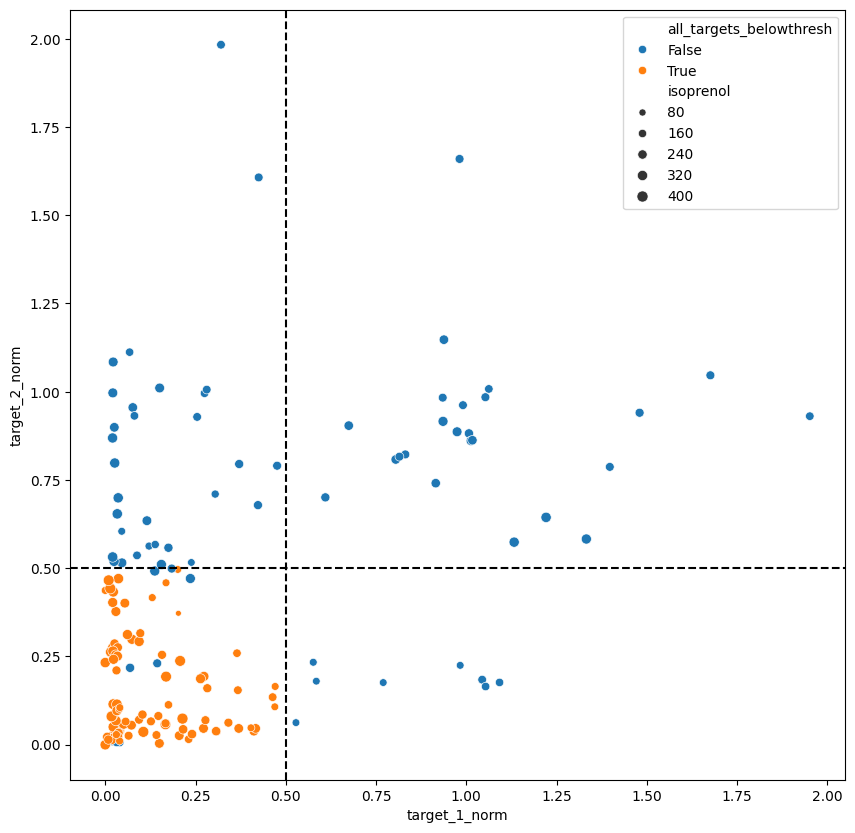

In [65]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(df_target, x = 'target_1_norm', y = 'target_2_norm', size = 'isoprenol', hue = 'all_targets_belowthresh')
ax.axhline(TARGET_THRESH, color = 'k', linestyle = '--')
ax.axvline(TARGET_THRESH, color = 'k', linestyle = '--')

Isoprenol distribution based on whether all targets are above or below the threshold. 

<Axes: xlabel='all_targets_belowthresh', ylabel='isoprenol'>

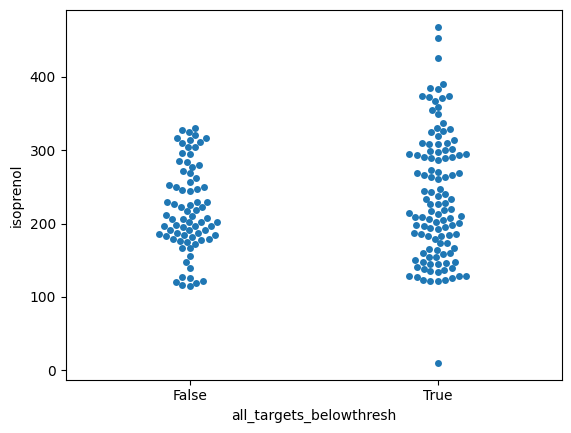

In [66]:
sns.swarmplot(df_target, y = 'isoprenol', x = 'all_targets_belowthresh')

### 3.4. Check whether all replicates are below threshold. 

Make a dataframe with Line Names as rows and group by whether all replicates for that line are below the threshold

In [67]:
df_target_grouped = df_target[['line_name_norep','all_targets_belowthresh']].groupby('line_name_norep').all()
df_target_grouped.loc['Control','all_targets_belowthresh']

True

In [68]:
print(f'There are N = {df_target_grouped["all_targets_belowthresh"].sum()} strains out of N = {len(df_target_grouped)} total strains with all targets below threshold')

There are N = 30 strains out of N = 58 total strains with all targets below threshold


Add field for whether all replicates are below the threshold. 

In [69]:
df_target['all_reps_belowthresh'] = df_target['line_name_norep'].apply(lambda x: df_target_grouped.loc[x, 'all_targets_belowthresh']).astype(bool)

In [70]:
df_all_reps_above_dcas9_thresh = df_target[['line_name_norep','above_dcas9_thresh']].groupby('line_name_norep').all()
df_all_reps_above_dcas9_thresh.loc[:,'above_dcas9_thresh']
df_target['all_reps_above_dcas9_thresh'] = df_target['line_name_norep'].apply(lambda x: df_all_reps_above_dcas9_thresh.loc[x, 'above_dcas9_thresh']).astype(bool)

Plot isoprenol distribution for Lines with all replicates below threshold.

<Axes: xlabel='all_reps_belowthresh', ylabel='isoprenol'>

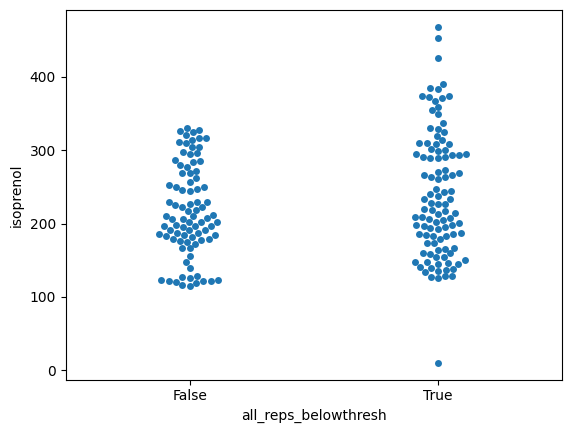

In [71]:
sns.swarmplot(df_target, y = 'isoprenol', x = 'all_reps_belowthresh')

### 3.5 Apply filters to lines based on target expression, dcas9 expression, and missing controls

In [72]:
df_target['to_keep'] = (df_target['all_reps_belowthresh'] | df_target['has_missing_control']) & df_target['above_dcas9_thresh']
df_target['to_keep_improved'] = (df_target['all_reps_belowthresh']) & (df_target['above_dcas9_thresh'])
df_target.to_csv('./dbtl1_figures_and_analysis/dbtl1_df_target.csv')

In [73]:
df_target.loc[(df_target['to_keep']) & (~df_target['to_keep_improved']),'line_name_norep'].unique()

array(['PP_0658_PP_0815_PP_4187'], dtype=object)

In [74]:
df_target.loc[df_target['line_name_norep'] == 'PP_0815_PP_1317',['target_1', 'target_1_norm','target_1_belowthresh', 'target_2', 'target_2_norm', 'target_2_belowthresh', 'all_targets_belowthresh']]

,target_1,target_1_norm,target_1_belowthresh,target_2,target_2_norm,target_2_belowthresh,all_targets_belowthresh
148,PP_0815,NaN,True,PP_1317,0.012326,True,True
156,PP_0815,NaN,True,PP_1317,0.009889,True,True
164,PP_0815,NaN,True,PP_1317,0.012407,True,True


In [75]:
df_target.head(3)

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,target_4_belowthresh,all_targets_belowthresh,all_reps_belowthresh,all_reps_above_dcas9_thresh,to_keep,to_keep_improved
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288,3,173.9811,4446120.70,0.513739,PP_0226,PP_0897,...,True,True,True,True,False,True,True,True,True,True
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192,3,268.6526,6229968.25,0.719859,PP_1319,PP_1457,...,True,True,False,True,False,False,False,True,False,False
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266,3,182.8489,5220820.10,0.603254,PP_2213,PP_2471,...,True,True,True,True,False,True,True,True,True,True


Text(0.5, 1.0, 'Titer by final filter - dCas9 thresh = 0.25 - target thresh = 0.5')

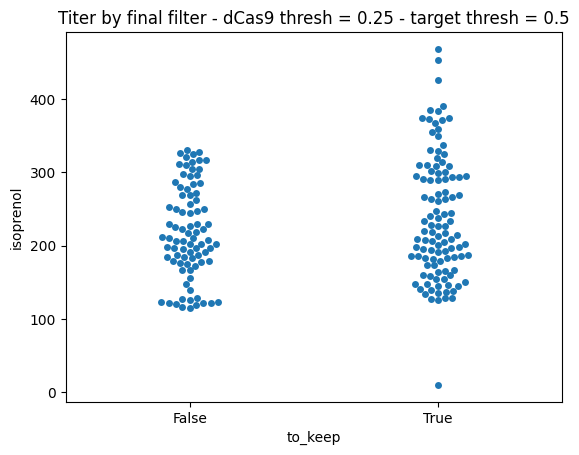

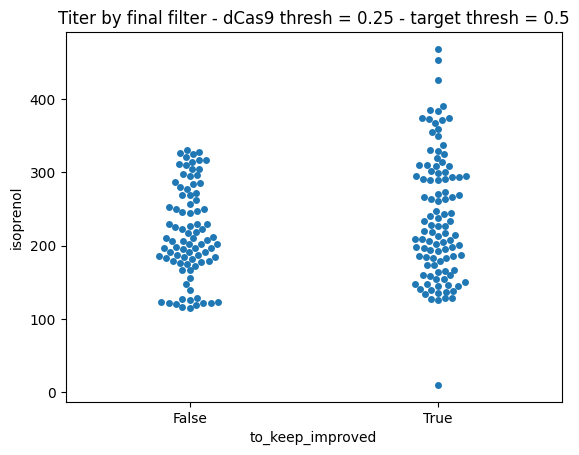

In [76]:
plt.figure()
sns.swarmplot(df_target, x = 'to_keep', y = 'isoprenol')
plt.title(f'Titer by final filter - dCas9 thresh = {DCAS9_THRESH} - target thresh = {TARGET_THRESH}')
plt.figure()
sns.swarmplot(df_target, x = 'to_keep_improved', y = 'isoprenol')
plt.title(f'Titer by final filter - dCas9 thresh = {DCAS9_THRESH} - target thresh = {TARGET_THRESH}')

Save csv with the lines to keep

In [77]:
lines_to_keep_fname = f'./dbtl1_proteomics_analysis/filtered_lines_df_dcas9thresh_{DCAS9_THRESH}_targetthresh_{TARGET_THRESH}.csv'
df_target.loc[df_target['to_keep'], ['Line Name', 'line_name_norep','to_keep']].to_csv(lines_to_keep_fname)

In [78]:
print(f"After filtering, keeping N = {len(df_target.loc[df_target['to_keep'], 'line_name_norep'].unique())} lines out of N = {len(df_target.loc[~df_target['to_keep'], 'line_name_norep'].unique())} total lines")

After filtering, keeping N = 31 lines out of N = 27 total lines


## 4. Proteomics plots

Plot dCas9 expression against target expression and filter by whether the proteins are above or below the threshold.

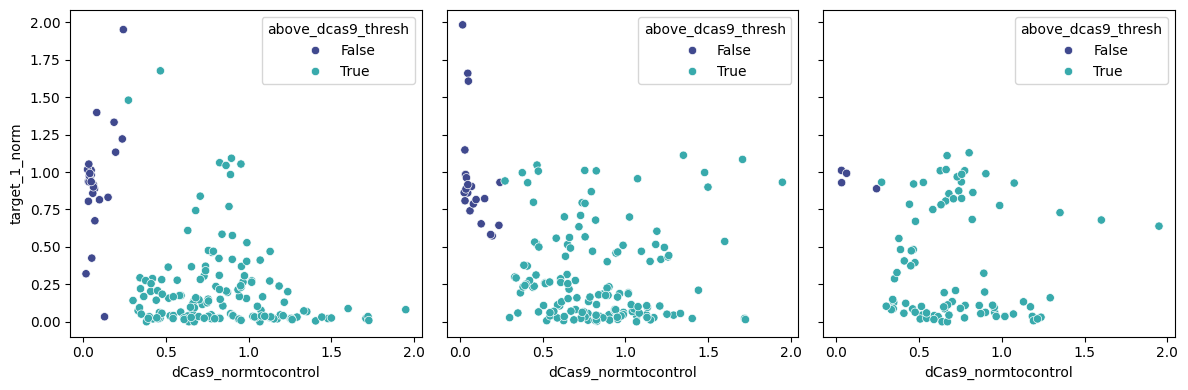

In [79]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_1_norm', hue = 'above_dcas9_thresh', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_2_norm', hue = 'above_dcas9_thresh', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_3_norm', hue = 'above_dcas9_thresh', ax = ax[2], palette = 'mako')
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/dCas9_vs_target_normalized_scatter.png')

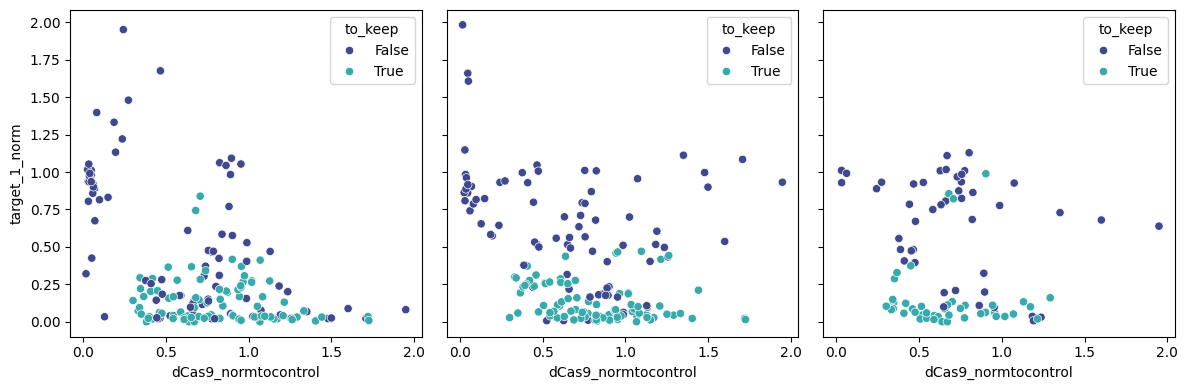

In [80]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_1_norm', hue = 'to_keep', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_2_norm', hue = 'to_keep', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_3_norm', hue = 'to_keep', ax = ax[2], palette = 'mako')
fig.tight_layout()
# fig.savefig('dbtl1_proteomics_analysis/dCas9_vs_target_normalized_scatter.png')

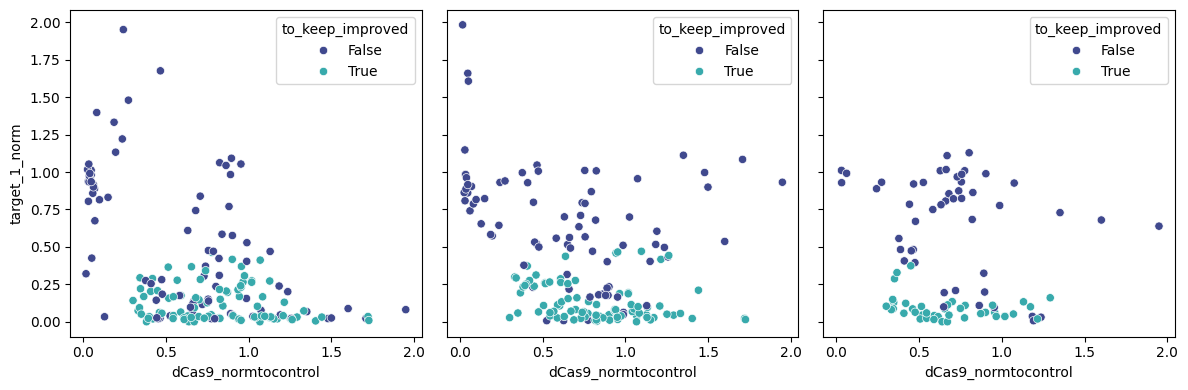

In [81]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_1_norm', hue = 'to_keep_improved', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_2_norm', hue = 'to_keep_improved', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_3_norm', hue = 'to_keep_improved', ax = ax[2], palette = 'mako')
fig.tight_layout()
# fig.savefig('dbtl1_proteomics_analysis/dCas9_vs_target_normalized_scatter.png')

Plot normalized target expression vs total target expression.

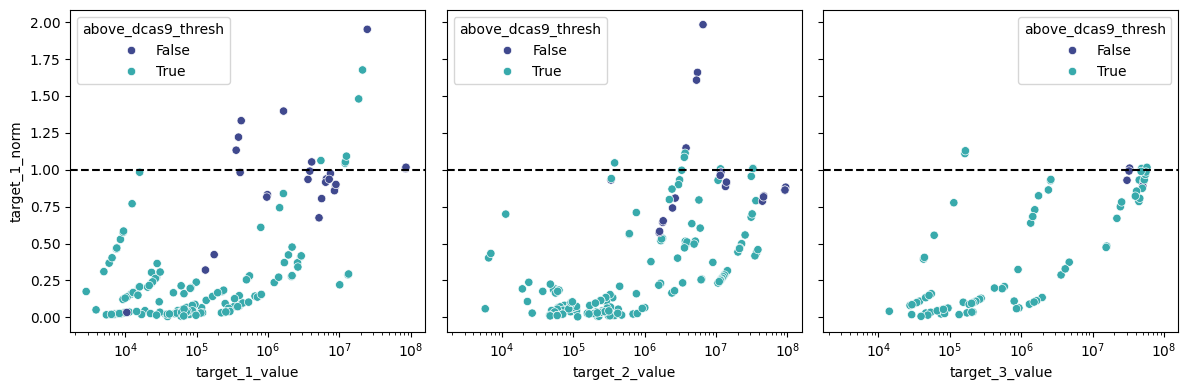

In [82]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'target_1_value', y = 'target_1_norm', hue = 'above_dcas9_thresh', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'target_2_value', y = 'target_2_norm', hue = 'above_dcas9_thresh', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'target_3_value', y = 'target_3_norm', hue = 'above_dcas9_thresh', ax = ax[2], palette = 'mako')
[axis.set_xscale('log') for axis in ax]
[axis.axhline(1, color = 'k', linestyle = '--') for axis in ax]
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/target_vs_target_normalized_scatter.png')

Plot the measurement of each target in the targeted strain vs the measurement of that protein in the control.

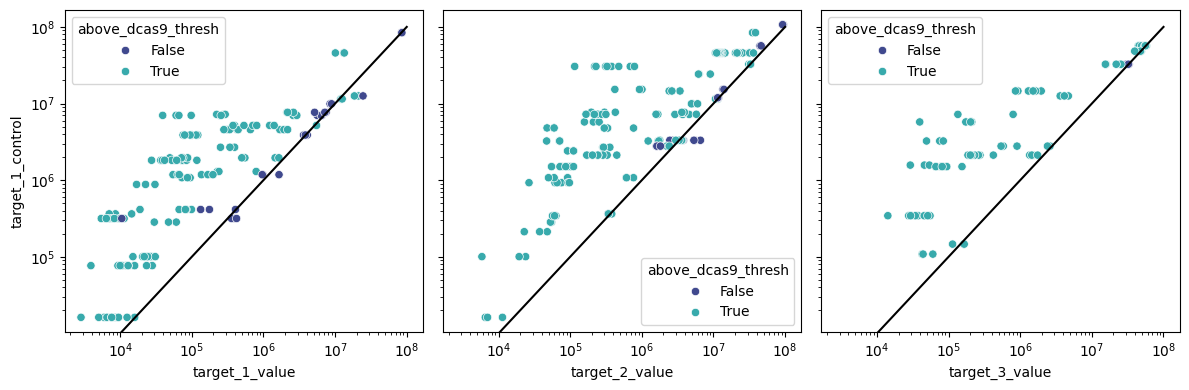

In [83]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'target_1_value', y = 'target_1_control', hue = 'above_dcas9_thresh', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'target_2_value', y = 'target_2_control', hue = 'above_dcas9_thresh', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'target_3_value', y = 'target_3_control', hue = 'above_dcas9_thresh', ax = ax[2], palette = 'mako')
[axis.set_xscale('log') for axis in ax]
[axis.set_yscale('log') for axis in ax]
[axis.plot([0,1e8], [0, 1e8], 'k') for axis in ax]
fig.tight_layout()
# fig.savefig('dbtl1_proteomics_analysis/target_vs_target_normalized_scatter.png')

Add normalized isoprenol to plot

In [84]:
mean_control_isoprenol = np.mean(df_target.loc[df_target['is_control'], 'isoprenol'])
df_target['isoprenol_norm'] = df_target['isoprenol']/mean_control_isoprenol

Melt dataframe to plot bargraph.

In [85]:
df_bar = pd.melt(df_target[~df_target['above_dcas9_thresh']].sort_values(by= 'Line Name'), id_vars = ['Line Name', 'line_name_norep'], value_vars=['target_1_norm', 'target_2_norm', 'dCas9_normtocontrol'])
df_bar

,Line Name,line_name_norep,variable,value
0,PP_0751_PP_1620_PP_4678-R2,PP_0751_PP_1620_PP_4678,target_1_norm,1.951392
1,PP_0774_PP_1769-R1,PP_0774_PP_1769,target_1_norm,0.981325
2,PP_0774_PP_1769-R2,PP_0774_PP_1769,target_1_norm,0.320556
3,PP_0774_PP_1769-R3,PP_0774_PP_1769,target_1_norm,0.424999
4,PP_0812_PP_4121-R1,PP_0812_PP_4121,target_1_norm,0.674404
...,...,...,...,...
73,PP_1607_PP_4550-R2,PP_1607_PP_4550,dCas9_normtocontrol,0.057835
74,PP_1607_PP_4550-R3,PP_1607_PP_4550,dCas9_normtocontrol,0.061724
75,PP_2339_PP_4186-R1,PP_2339_PP_4186,dCas9_normtocontrol,0.042341
76,PP_2339_PP_4186-R2,PP_2339_PP_4186,dCas9_normtocontrol,0.047722


Bar graph of normalized dCas9 and target 1 and 2 expression for strains that failed filter.

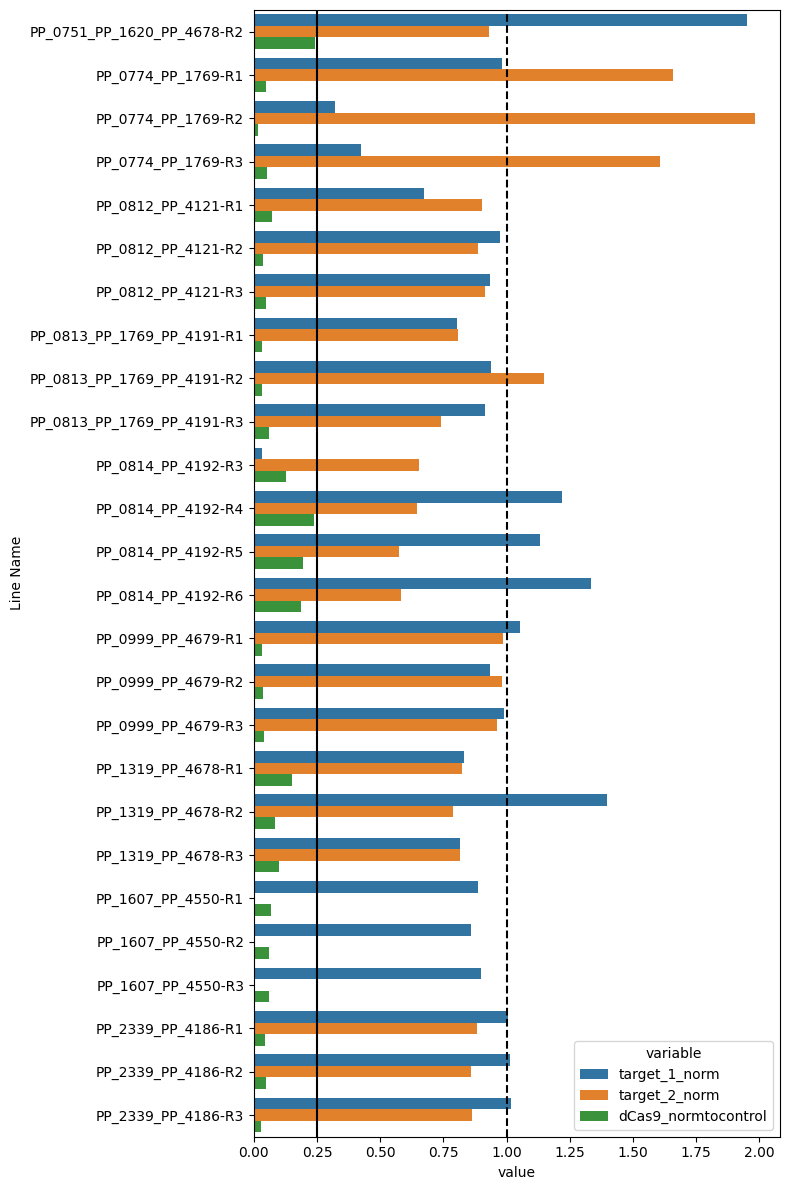

In [86]:
fig, ax = plt.subplots(figsize = (8,12))
sns.barplot(df_bar, y = 'Line Name', x = 'value', hue = 'variable', ax = ax)
ax.axvline(0.25, color = 'k')
ax.axvline(1, color = 'k', linestyle = '--')
# fig.legend(['target 1 norm', 'dCas9 norm', 'target 2 norm', 'dCas9 threshold', '1'])
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/bar_graph_for_failing_strains_sortbyname.png')

/tmp/ipykernel_17419/1518205847.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bp.set_xticklabels(bp.get_xticklabels(),


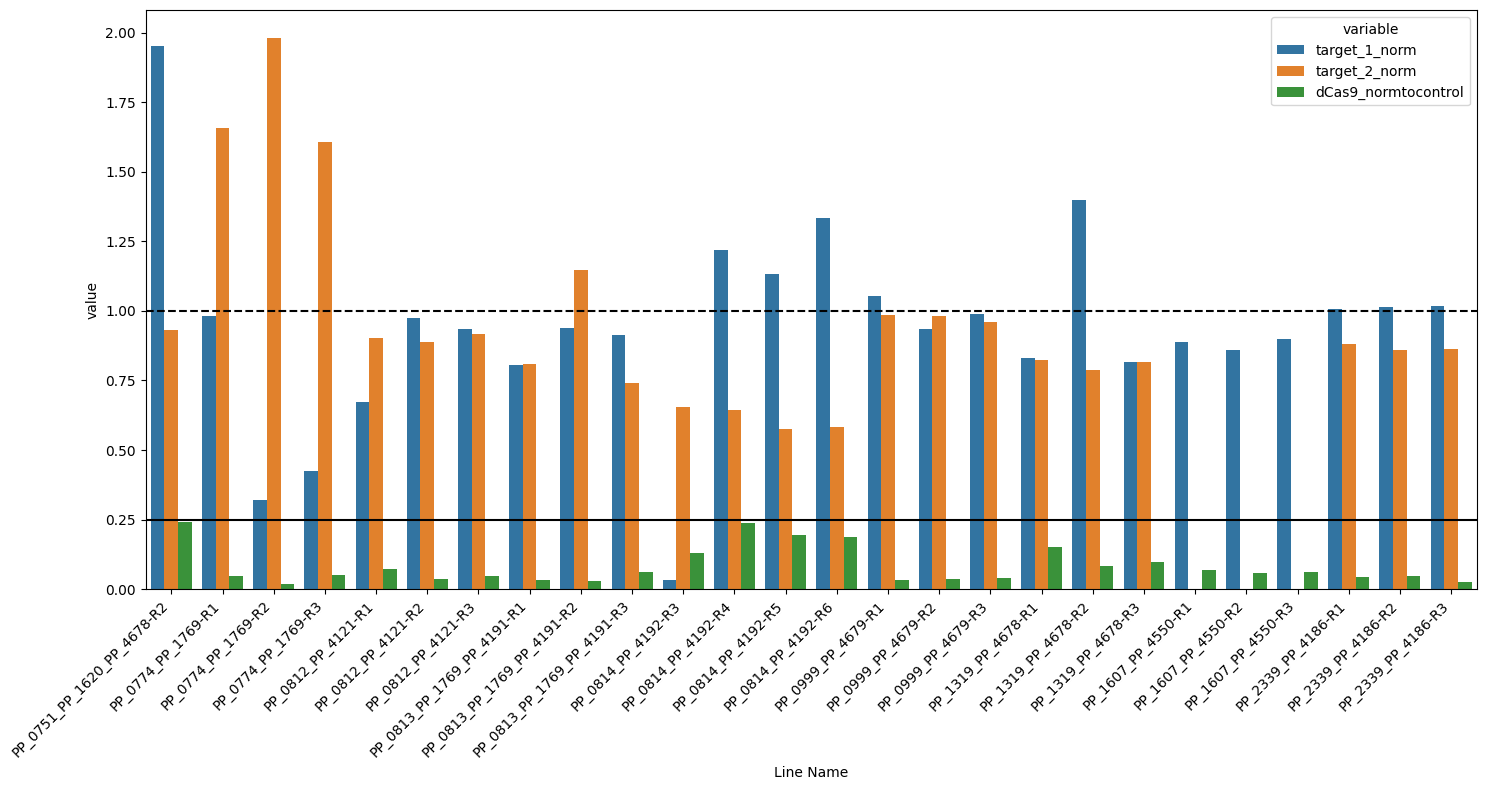

In [87]:
fig, ax = plt.subplots(figsize = (15,8))
bp = sns.barplot(df_bar, x = 'Line Name', y = 'value', hue = 'variable', ax = ax)
ax.axhline(0.25, color = 'k')
ax.axhline(1, color = 'k', linestyle = '--')
bp.set_xticklabels(bp.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/bar_graph_for_failing_strains_sortbyname_rotate.png')

Plot distribution of isoprenol based on passing dCas9 threshold.

<Axes: xlabel='above_dcas9_thresh', ylabel='isoprenol_norm'>

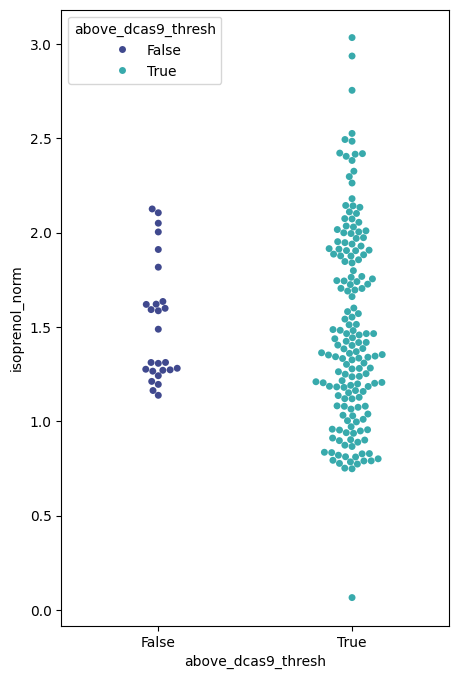

In [88]:
fig, ax = plt.subplots(figsize = (5,8))
sns.swarmplot(df_target, y = 'isoprenol_norm', x = 'above_dcas9_thresh', hue = 'above_dcas9_thresh', palette= 'mako')

Scatter plot of normalized target expression with information on dCas9 levels (size and color)

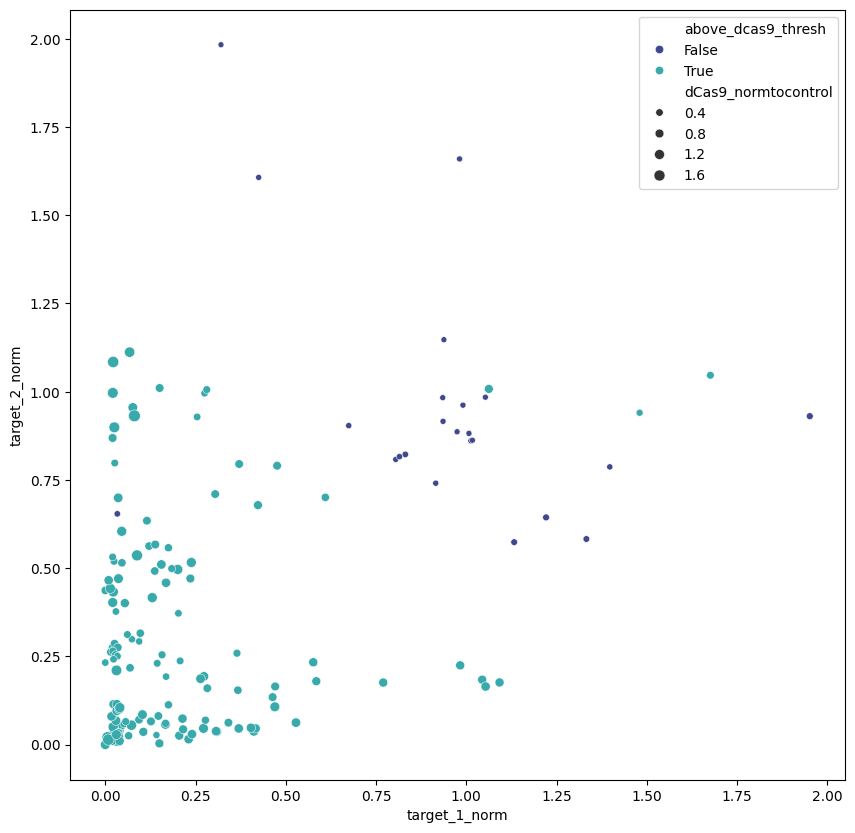

In [89]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(df_target, x = 'target_1_norm', y = 'target_2_norm', size = 'dCas9_normtocontrol', hue = 'above_dcas9_thresh', palette = 'mako')
fig.savefig('Crispri_dcas9_eval.png')

Scatter plot of non-normalized target expression with information on dCas9 levels (size and color)

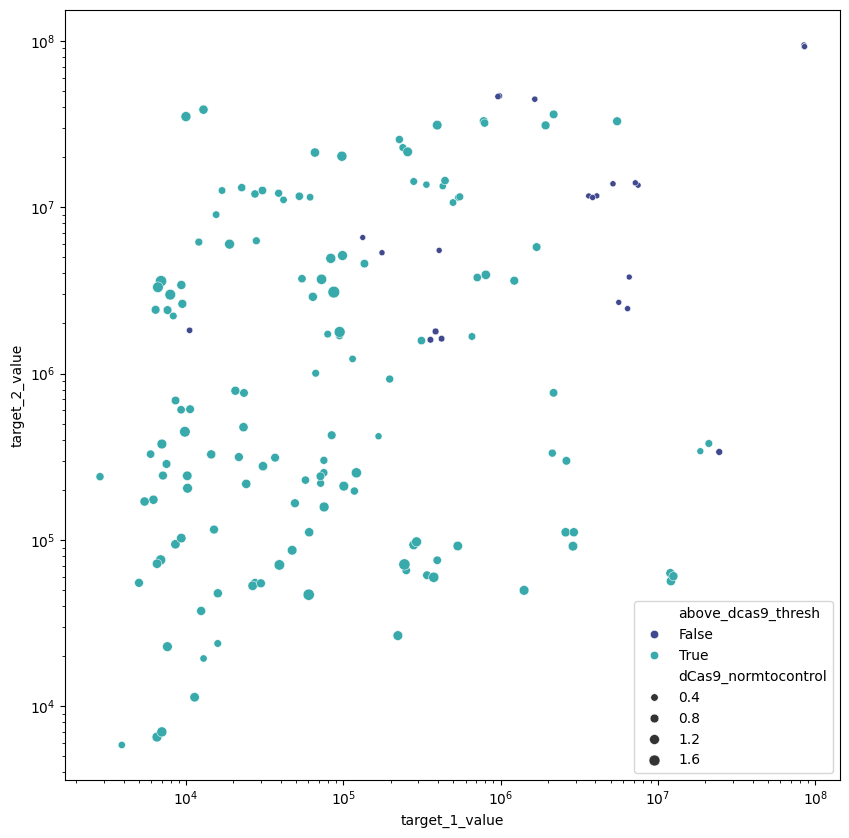

In [90]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(df_target, x = 'target_1_value', y = 'target_2_value', size = 'dCas9_normtocontrol', hue = 'above_dcas9_thresh', palette = 'mako')
ax.set_xscale('log')
ax.set_yscale('log')

146104.56


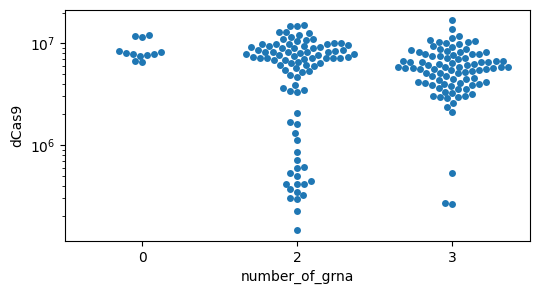

In [91]:
fig, ax = plt.subplots(figsize = (6,3))
ax.set_yscale('log')
sns.swarmplot(data = df_target, y = 'dCas9',x = 'number_of_grna', ax = ax)
# ax.set_ylim([-1e6, 1e6])
ax.axhline(0, color = 'k')
print(df_target['dCas9'].min())

/tmp/ipykernel_17419/3532989697.py:2: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.countplot(data = df_target[(df_target['rep'] == 1) & (~df_target['is_control'])],


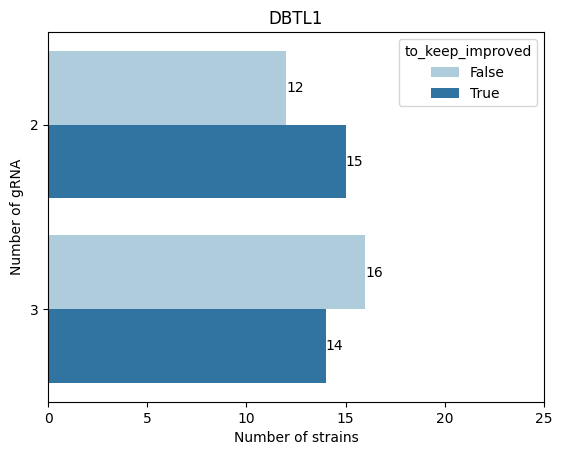

In [92]:
fig, ax = plt.subplots()
sns.countplot(data = df_target[(df_target['rep'] == 1) & (~df_target['is_control'])],
              y = 'number_of_grna',
              hue = 'to_keep_improved',
              palette = sns.color_palette('Paired')
             )
ax.set_title('DBTL1')
ax.set_xlabel('Number of strains')
ax.set_ylabel('Number of gRNA')
ax.set_xlim([0, 25])
plt.xticks(np.arange(0, 26, 5))
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
fig.savefig(f"{user_params['output_dir']}filter_passage_by_num_gRNA_DBTL1.png")
fig.savefig(f"{user_params['output_dir']}filter_passage_by_num_gRNA_DBTL1.pdf")